In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalMaxPooling1D, Embedding, LSTM, Dense
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import string
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

df_1 = pd.read_csv('/content/drive/MyDrive/DATASETS/Twitter_Data.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/DATASETS/Reddit_Data.csv')
df_2.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


<Axes: xlabel='category'>

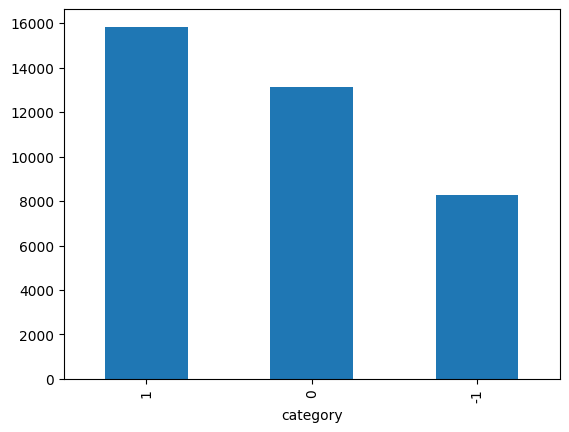

In [ ]:
# prompt: Using dataframe df_2:

# Create a bar chart showing the count of comments in each category
df_2['category'].value_counts().plot(kind='bar')


In [ ]:
df_1.columns = ['message', 'label']
df_2.columns = ['message', 'label']

In [ ]:
df = pd.concat([df_1, df_2], ignore_index =True)
df.head(5)

,message,label
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
df['message'].iloc[0]

'when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples'

In [ ]:
df.head()

,message,label
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
df['length'] = df['message'].str.len()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200229 entries, 0 to 200228
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   message  200125 non-null  object 
 1   label    200222 non-null  float64
 2   length   200125 non-null  float64
dtypes: float64(2), object(1)
memory usage: 4.6+ MB


<Axes: ylabel='Frequency'>

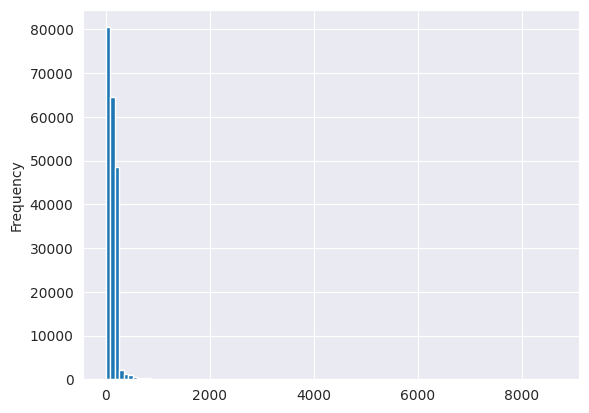

In [ ]:
sns.set_style('darkgrid')
df['length'].plot(bins=100, kind='hist')

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
label,200222.0,0.221219,0.780813,-1.0,0.0,0.0,1.0,1.0
length,200125.0,134.796737,167.639234,1.0,61.0,109.0,183.0,8665.0


In [ ]:
df[df['length'] == 8665]['message'].iloc[0]

'brilliant point point breakdown one other argument making the rounds false argument okay maybe the strikes took place but should have been kept secret and deniable there good reason for dgmo make statements about covert actions except for bjp score political points there are massive number reasons make strike like this public exposes pakistan bluster just tough talk for all their talk being high alert for indian troop movement along the loc after the uri attack they didn even see coming massively boosts morale within the armed forces morale which has been getting steadily lower our bases kept getting hit while they were not allowed take charge the offensive the troops are also being vilified the media national and international while trying control spiral violence srinagar fueled pakistan propaganda machine makes the best use pakistan blunder overreaching and outmaneuvers them pakistan has its hands tied now after making bold statements about defending against indian adventurism aggre

In [ ]:
df['label'] = df['label'].map({-1: 'negative', 0: 'neutral', 1: 'positive'})

In [ ]:
#Checking the null values in the dataset
df.isnull().sum()

message    104
label        7
length     104
dtype: int64

In [ ]:

#drop the null values
df = df.dropna()

In [ ]:
len(df['message'])

200118

In [ ]:
#replacing url with string
def replace_url(text):
  return re.sub('https?:\/\/S*|www\.\S+', 'URL', text)


In [ ]:
#removing html
def remove_html(text):
    return re.sub('<.*?>', '', text)

In [ ]:
#replacing mentions with string user
def replace_mentions(text):
    return re.sub('@\S*','user',text,flags=re.IGNORECASE)

In [ ]:
#replacing number with string number
def replace_num(text):
    return re.sub('^[+-]*?\d{1,3}[- ]*?\d{1,10}|\d{10}','NUMBER',text)

In [ ]:
def replace_heart(text):
  return re.sub('<3', 'HEART', text)

In [ ]:
def remove_stopwords(text):
  text= ' '.join([word for word in text.split() if word not in stopwords.words('english')])
  return text

In [ ]:
def remove_punctuations(text):
    text=''.join([word for word in text if word not in string.punctuation])
    return text

In [ ]:
def remove_alphanumeric(text):
    return re.sub('\w*\d+\w*','',text)

In [ ]:
#reducing words to their root form
def lemmatization(text):
  lm = WordNetLemmatizer()
  text= ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
  return text

In [ ]:
def clean_text(text):
  text = str(text).lower()
  text =replace_url(text)
  text = remove_punctuations(text)
  text = remove_alphanumeric(text)
  text = replace_heart(text)
  text = remove_stopwords(text)
  text = remove_html(text)
  text = replace_mentions(text)
  text = lemmatization(text)
  text = replace_num(text)
  return text



In [ ]:
X = df['message'].values
y = pd.get_dummies(df['label']).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...


In [ ]:
from nltk.corpus import wordnet
df['message'] = df['message'].apply(clean_text)

In [ ]:
df['message']

0         modi promise “minimum government maximum gover...
1                    talk nonsense continue drama vote modi
2         say vote modi welcome bjp tell rahul main camp...
3         ask supporters prefix chowkidar name modi grea...
4         answer among powerful world leader today trump...
                                ...                        
200224                                                jesus
200225    kya bhai pure saal chutiya banaya modi aur jab...
200226                 downvote karna tha par upvote hogaya
200227                                            haha nice
200228                              facebook work bjp’ cell
Name: message, Length: 200118, dtype: object

In [ ]:
X = df['message'].values
y =pd.get_dummies(df['label']).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
X_train.shape

(134079,)

In [ ]:
Max_vocab_size = 50000
tokenizer = Tokenizer(num_words = Max_vocab_size)
tokenizer.fit_on_texts(X_train)
sequence_Xtrain = tokenizer.texts_to_sequences(X_train)
sequence_Xtest = tokenizer.texts_to_sequences(X_test)

In [ ]:
V= len(tokenizer.word_index)
tokenizer.word_index

{'modi': 1,
 'india': 2,
 'say': 3,
 'people': 4,
 'bjp': 5,
 'like': 6,
 'get': 7,
 'give': 8,
 'congress': 9,
 'make': 10,
 'vote': 11,
 'one': 12,
 'time': 13,
 'narendra': 14,
 'take': 15,
 'know': 16,
 'govt': 17,
 'want': 18,
 'come': 19,
 'think': 20,
 'even': 21,
 'country': 22,
 'see': 23,
 'also': 24,
 'dont': 25,
 'indian': 26,
 'years': 27,
 'party': 28,
 'good': 29,
 'would': 30,
 'election': 31,
 'go': 32,
 'work': 33,
 'modis': 34,
 'government': 35,
 'rahul': 36,
 'need': 37,
 'nation': 38,
 'power': 39,
 'minister': 40,
 'support': 41,
 'ask': 42,
 'pakistan': 43,
 'money': 44,
 'use': 45,
 'gandhi': 46,
 'win': 47,
 'credit': 48,
 'right': 49,
 'hai': 50,
 'back': 51,
 'do': 52,
 'become': 53,
 'every': 54,
 'show': 55,
 'many': 56,
 'much': 57,
 'space': 58,
 'never': 59,
 'job': 60,
 'call': 61,
 'media': 62,
 'new': 63,
 'well': 64,
 'elections': 65,
 'prime': 66,
 'live': 67,
 'question': 68,
 'sir': 69,
 'promise': 70,
 'state': 71,
 'still': 72,
 'look': 73,
 't

In [ ]:
data_train = pad_sequences(sequence_Xtrain)

In [ ]:
T = data_train.shape[1]
print (T)

857


In [ ]:
data_test = pad_sequences(sequence_Xtest, maxlen=T)

In [ ]:
data_train.shape

(134079, 857)

In [ ]:
data_test.shape

(66039, 857)

In [ ]:
D=20
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(128, dropout=(0.2))(x)
x = Dense(3, activation='softmax')(x)
model = Model(i, x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(data_train, y_train, epochs=5, batch_size=128, validation_data=(data_test, y_test), callbacks=[early_stop])

Epoch 1/5
1048/1048 [==============================] - 106s 99ms/step - loss: 0.5426 - accuracy: 0.7851 - val_loss: 0.3668 - val_accuracy: 0.8741
Epoch 2/5
1048/1048 [==============================] - 68s 65ms/step - loss: 0.3323 - accuracy: 0.8863 - val_loss: 0.3495 - val_accuracy: 0.8803
Epoch 3/5
1048/1048 [==============================] - 62s 59ms/step - loss: 0.2896 - accuracy: 0.9009 - val_loss: 0.3572 - val_accuracy: 0.8801
Epoch 4/5
1048/1048 [==============================] - 64s 61ms/step - loss: 0.2625 - accuracy: 0.9116 - val_loss: 0.3685 - val_accuracy: 0.8771


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 857)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 857, 20)           1870260   
                                                                 
 lstm_1 (LSTM)               (None, 128)               76288     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1946935 (7.43 MB)
Trainable params: 1946935 (7.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.evaluate(data_test, y_test)

2064/2064 [==============================] - 28s 13ms/step - loss: 0.3685 - accuracy: 0.8771


[0.36850860714912415, 0.8770726323127747]

<Axes: >

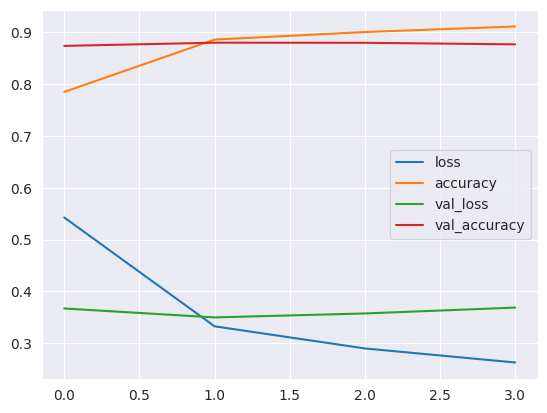

In [ ]:
losses= pd.DataFrame(history.history)
losses.plot()

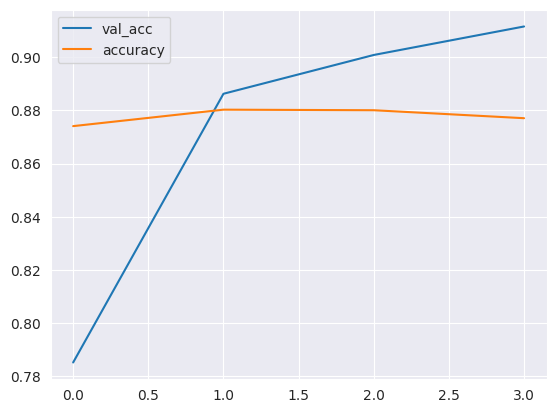

In [ ]:
plt.plot(history.history['accuracy'], label='val_acc')
plt.plot(history.history['val_accuracy'], label='accuracy')
plt.legend()

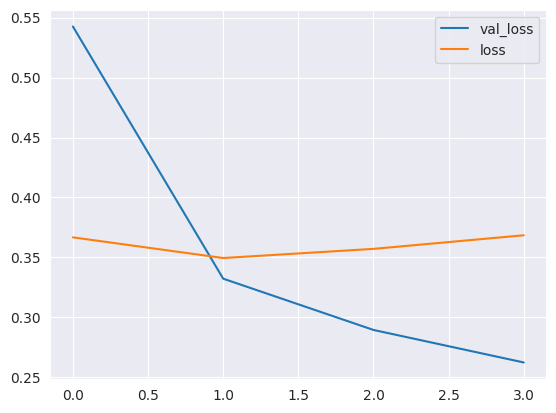

In [ ]:
plt.plot(history.history['loss'], label='val_loss')
plt.plot(history.history['val_loss'], label='loss')
plt.legend()

In [ ]:
predictions = model.predict(data_test).argmax(axis=1)

2064/2064 [==============================] - 32s 15ms/step


In [ ]:
print (classification_report(y_test.argmax(axis=1), predictions))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82     14456
           1       0.89      0.91      0.90     22696
           2       0.89      0.89      0.89     28887

    accuracy                           0.88     66039
   macro avg       0.87      0.87      0.87     66039
weighted avg       0.88      0.88      0.88     66039



In [ ]:
model.save('model.h5')